# Klasifikasi Tingkat Kesuburan Lahan Pertanian Berdasarkan Kandungan Nutrisi dan pH Tanah

In [3]:
# Import library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Memuat dataset
data = pd.read_csv('/content/drive/MyDrive/Data Mining/UAS/dataset1.csv')

# Menampilkan 5 baris awal dataset
print(data.head())

     N    P    K    pH    EC    OC     S    Zn    Fe    Cu    Mn     B  Output
0  138  8.6  560  7.46  0.62  0.70   5.9  0.24  0.31  0.77  8.71  0.11       0
1  213  7.5  338  7.62  0.75  1.06  25.4  0.30  0.86  1.54  2.89  2.29       0
2  163  9.6  718  7.59  0.51  1.11  14.3  0.30  0.86  1.57  2.70  2.03       0
3  157  6.8  475  7.64  0.58  0.94  26.0  0.34  0.54  1.53  2.65  1.82       0
4  270  9.9  444  7.63  0.40  0.86  11.8  0.25  0.76  1.69  2.43  2.26       1


In [6]:
# Eksplorasi awal dataset
print("\nInfo Dataset:")
print(data.info())

print("\nStatistik Deskriptif:")
print(data.describe())

print("\nDistribusi Output:")
print(data['Output'].value_counts())


Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   pH      880 non-null    float64
 4   EC      880 non-null    float64
 5   OC      880 non-null    float64
 6   S       880 non-null    float64
 7   Zn      880 non-null    float64
 8   Fe      880 non-null    float64
 9   Cu      880 non-null    float64
 10  Mn      880 non-null    float64
 11  B       880 non-null    float64
 12  Output  880 non-null    int64  
dtypes: float64(10), int64(3)
memory usage: 89.5 KB
None

Statistik Deskriptif:
               N           P           K          pH          EC          OC  \
count  880.00000  880.000000  880.000000  880.000000  880.000000  880.000000   
mean   246.73750   14.562159  499.978409    7.510500    0.543659    0.617989   
std  



> Pre-Processing



In [7]:
# Mengecek missing values
print("\nCek Missing Values:")
print(data.isnull().sum())


Cek Missing Values:
N         0
P         0
K         0
pH        0
EC        0
OC        0
S         0
Zn        0
Fe        0
Cu        0
Mn        0
B         0
Output    0
dtype: int64


In [8]:
# Mengecek data duplikat
print("\nJumlah data duplikat:", data.duplicated().sum())


Jumlah data duplikat: 0


In [9]:
# Normalisasi Data
scaler = MinMaxScaler()
columns_to_normalize = data.columns[:-1]  # Semua kolom kecuali 'Output'
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Deteksi dan Penanganan Outlier dengan IQR
Q1 = data[columns_to_normalize].quantile(0.25)
Q3 = data[columns_to_normalize].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan batas atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menangani outlier dengan mengganti nilai yang terdeteksi sebagai outlier dengan nilai batas
data[columns_to_normalize] = np.where(data[columns_to_normalize] < lower_bound, lower_bound, data[columns_to_normalize])
data[columns_to_normalize] = np.where(data[columns_to_normalize] > upper_bound, upper_bound, data[columns_to_normalize])

print("\nData setelah Normalisasi dan Penanganan Outlier:")
print(data.head())


Data setelah Normalisasi dan Penanganan Outlier:
          N         P         K        pH        EC        OC         S  \
0  0.350133  0.046683  0.626712  0.640000  0.611765  0.025105  0.173254   
1  0.549072  0.037674  0.373288  0.655610  0.764706  0.040167  0.467227   
2  0.416446  0.054873  0.807078  0.652683  0.482353  0.042259  0.449934   
3  0.400531  0.031941  0.529680  0.657561  0.564706  0.035146  0.467227   
4  0.700265  0.057330  0.494292  0.656585  0.352941  0.031799  0.367589   

         Zn        Fe        Cu        Mn         B  Output  
0  0.004054  0.002284  0.232082  0.278407  0.018116       0  
1  0.005485  0.014844  0.494881  0.089997  0.384058       0  
2  0.005485  0.014844  0.505119  0.083846  0.384058       0  
3  0.006439  0.007536  0.491468  0.082227  0.384058       0  
4  0.004293  0.012560  0.546075  0.075105  0.384058       1  




> Exploratory Data Analysis (EDA)



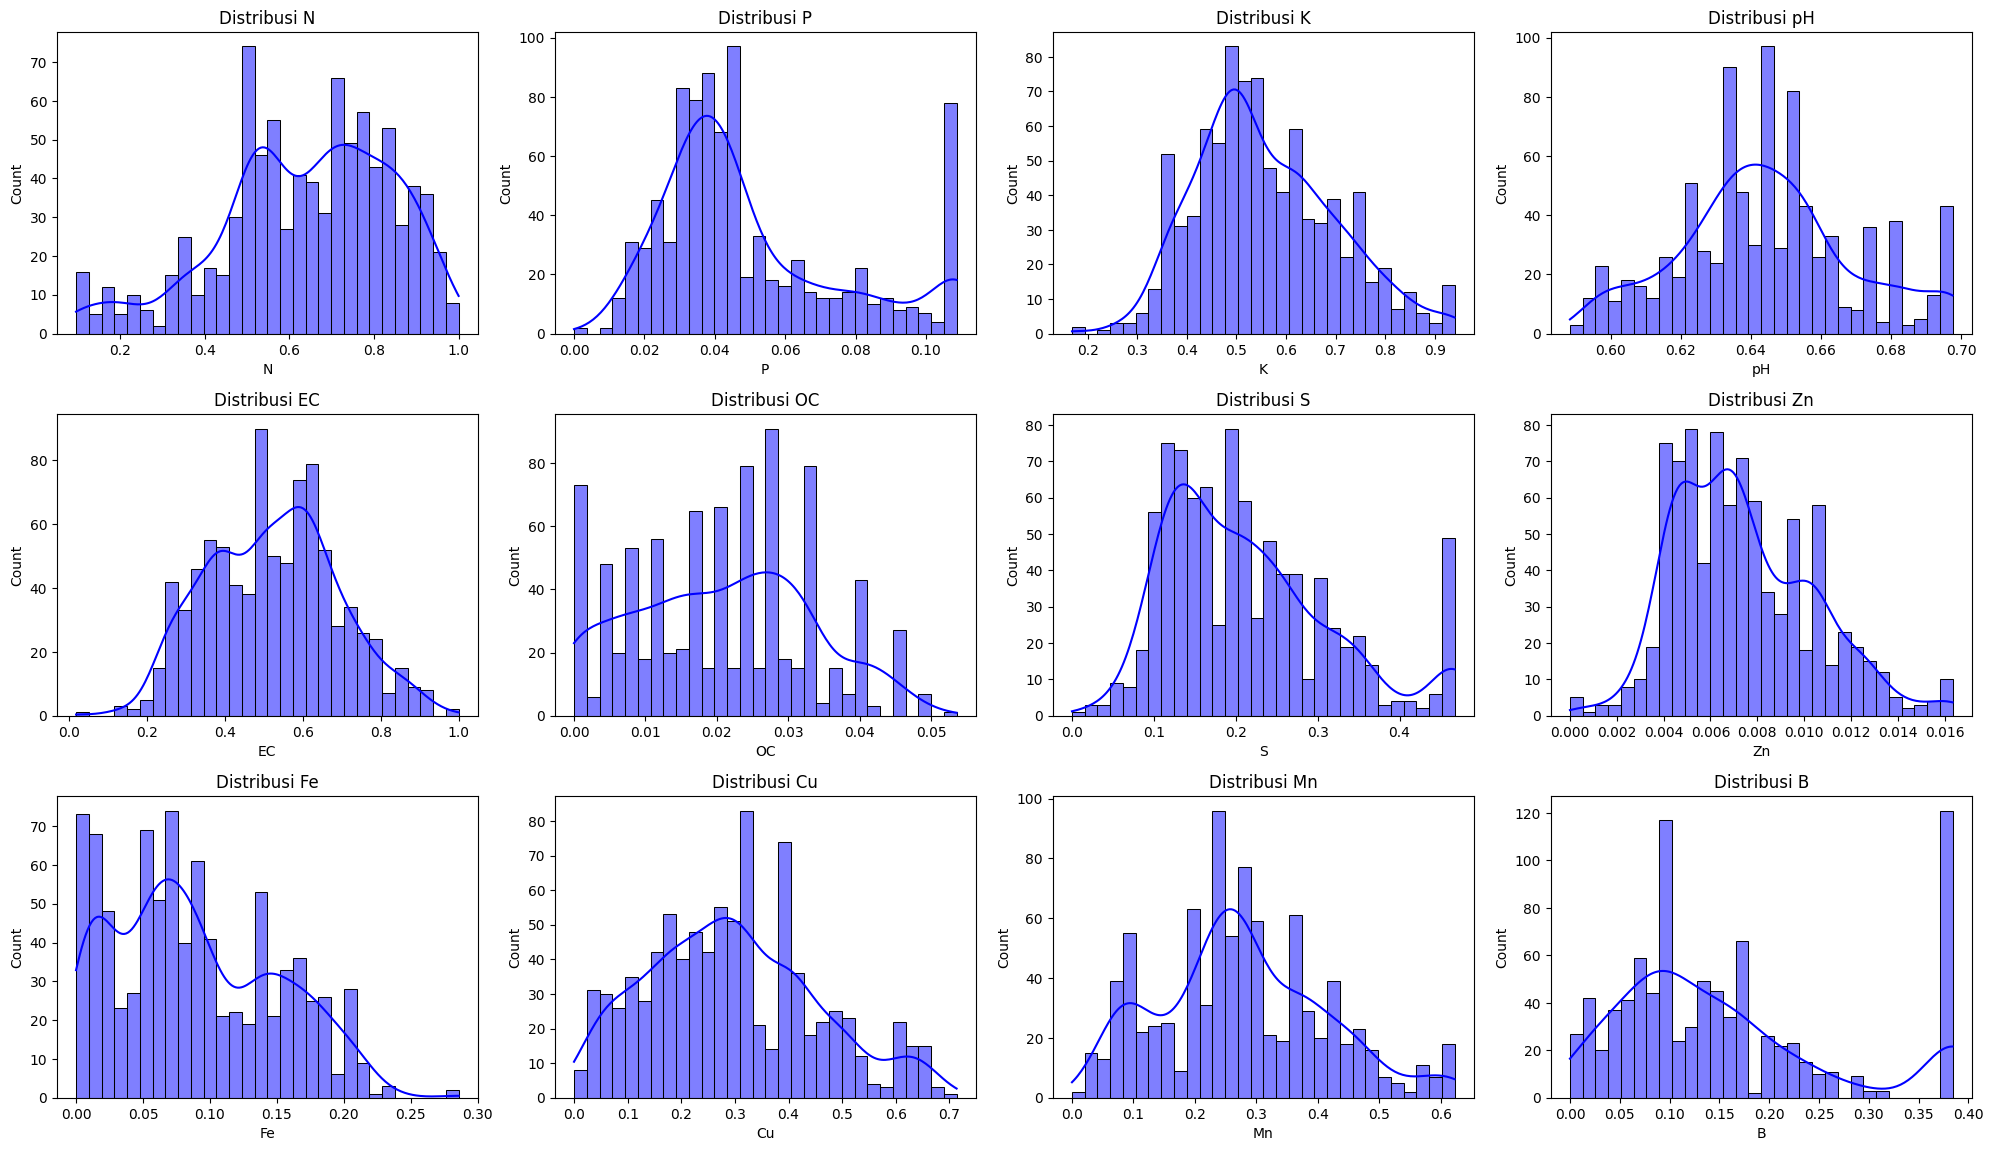

In [10]:
# Visualisasi distribusi setiap fitur
features = data.columns[:-1]
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()

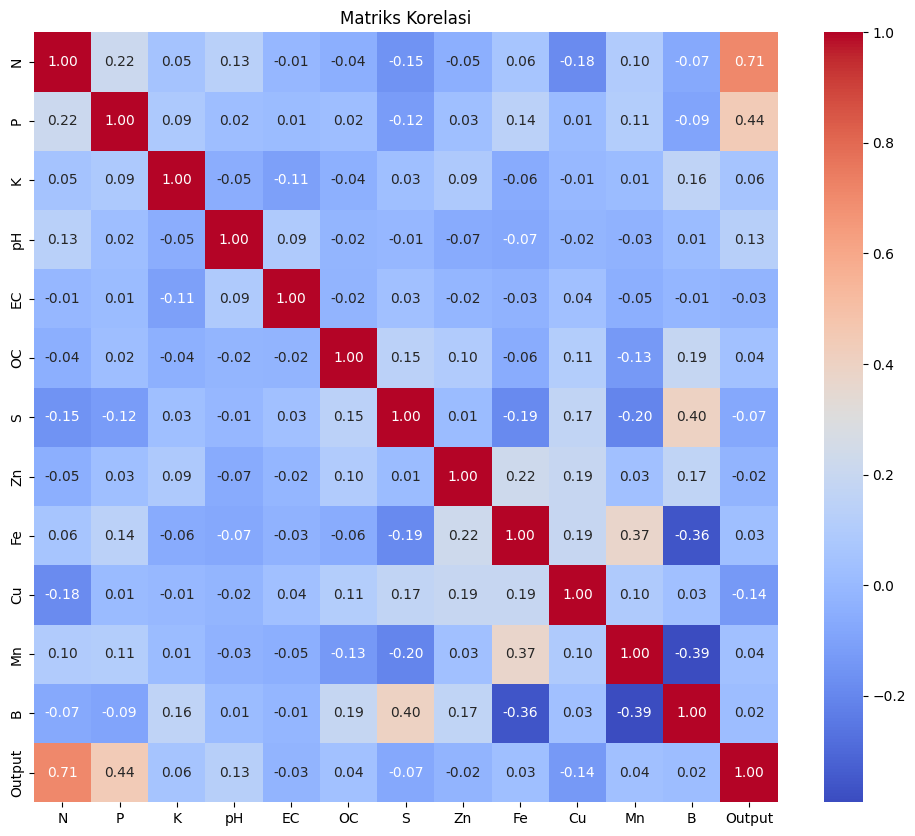

In [11]:
# Visualisasi korelasi antar fitur
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()

<ipython-input-12-6286af383e43>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Output'], y=data[feature], palette='Set2')
<ipython-input-12-6286af383e43>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Output'], y=data[feature], palette='Set2')
<ipython-input-12-6286af383e43>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Output'], y=data[feature], palette='Set2')
<ipython-input-12-6286af383e43>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

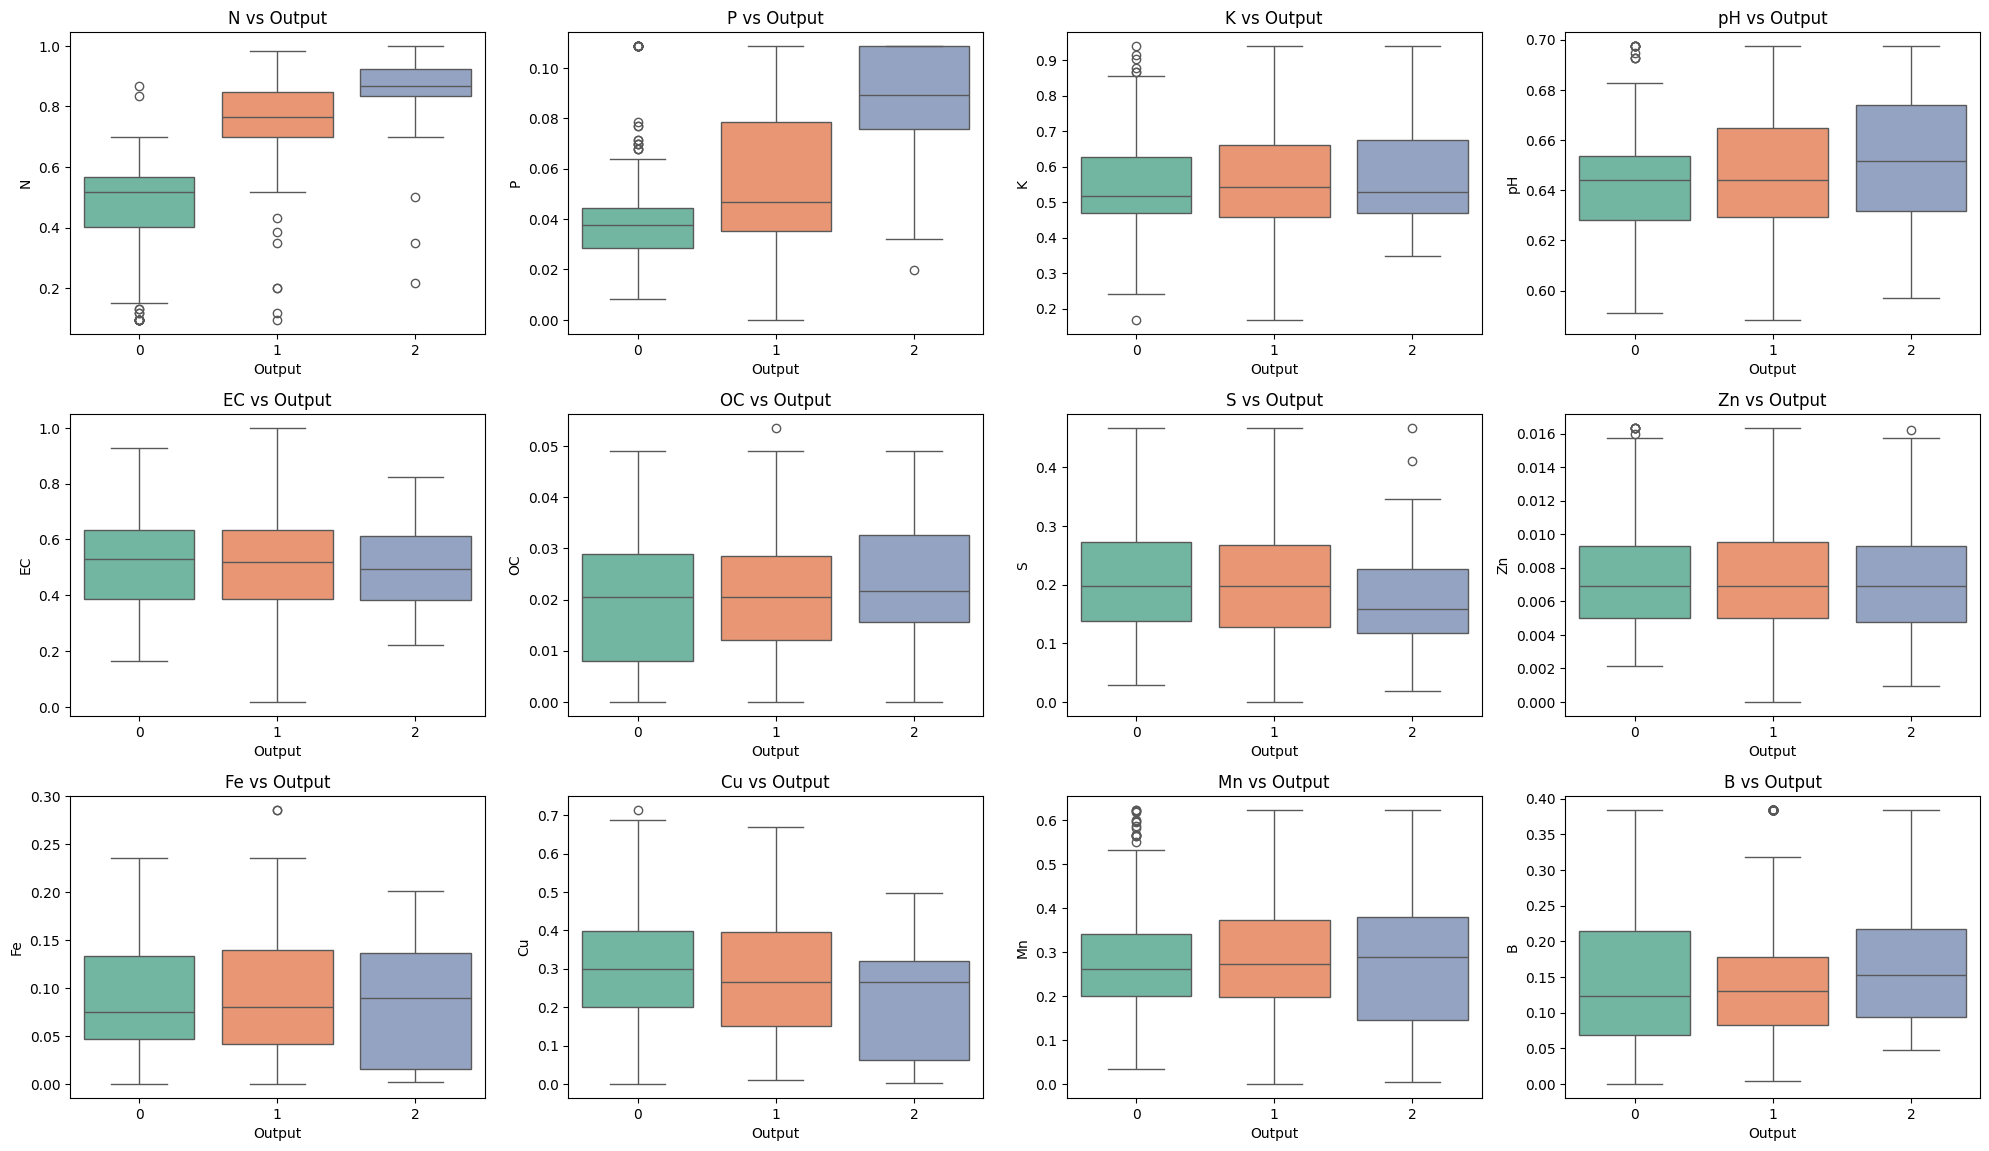

In [12]:
# Visualisasi hubungan antara fitur dan output
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x=data['Output'], y=data[feature], palette='Set2')
    plt.title(f'{feature} vs Output')
plt.tight_layout()
plt.show()

In [13]:
# Import necessary modules
from sklearn.feature_selection import SelectKBest, f_classif

# Seleksi Fitur
# Tentukan jumlah fitur terbaik yang ingin dipilih
k = 5  # Misalnya, pilih 5 fitur terbaik

# Inisialisasi objek SelectKBest dengan uji ANOVA (f_classif)
selector = SelectKBest(score_func=f_classif, k=k)

# Lakukan seleksi fitur
X_new = selector.fit_transform(data.drop(columns=['Output']), data['Output'])

# Dapatkan indeks fitur yang dipilih
selected_features_indices = selector.get_support(indices=True)

# Dapatkan nama fitur yang dipilih
selected_features = data.drop(columns=['Output']).columns[selected_features_indices]

# Cetak nama fitur yang dipilih
print("Fitur yang dipilih:", selected_features)

# Buat DataFrame baru dengan fitur yang dipilih
X_selected = pd.DataFrame(X_new, columns=selected_features)

# Gabungkan fitur yang dipilih dengan kolom target
data_selected = pd.concat([X_selected, data['Output']], axis=1)

# Sekarang data_selected berisi dataset dengan fitur-fitur yang telah dipilih
print("\nDataset dengan fitur terpilih:")
print(data_selected.head())

Fitur yang dipilih: Index(['N', 'P', 'pH', 'S', 'Cu'], dtype='object')

Dataset dengan fitur terpilih:
          N         P        pH         S        Cu  Output
0  0.350133  0.046683  0.640000  0.173254  0.232082       0
1  0.549072  0.037674  0.655610  0.467227  0.494881       0
2  0.416446  0.054873  0.652683  0.449934  0.505119       0
3  0.400531  0.031941  0.657561  0.467227  0.491468       0
4  0.700265  0.057330  0.656585  0.367589  0.546075       1


In [14]:
# Pemisahan Data
X = data_selected.drop(columns=['Output'])
y = data_selected['Output']

# Membagi data menjadi data latih (train) dan data uji (test) dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan ukuran data latih dan data uji
print("Ukuran data latih (X_train, y_train):", len(X_train), len(y_train))
print("Ukuran data uji (X_test, y_test):", len(X_test), len(y_test))

Ukuran data latih (X_train, y_train): 704 704
Ukuran data uji (X_test, y_test): 176 176


In [15]:
# Memeriksa distribusi kelas dalam data latih dan data uji
print("Distribusi kelas pada y_train:")
print(y_train.value_counts())

print("\nDistribusi kelas pada y_test:")
print(y_test.value_counts())

Distribusi kelas pada y_train:
Output
1    352
0    323
2     29
Name: count, dtype: int64

Distribusi kelas pada y_test:
Output
1    88
0    78
2    10
Name: count, dtype: int64


Distribusi Kelas Target:
 Output
1    440
0    401
2     39
Name: count, dtype: int64


<ipython-input-16-eb5f9d5f78f9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Output', data=data_selected, palette='Set2')


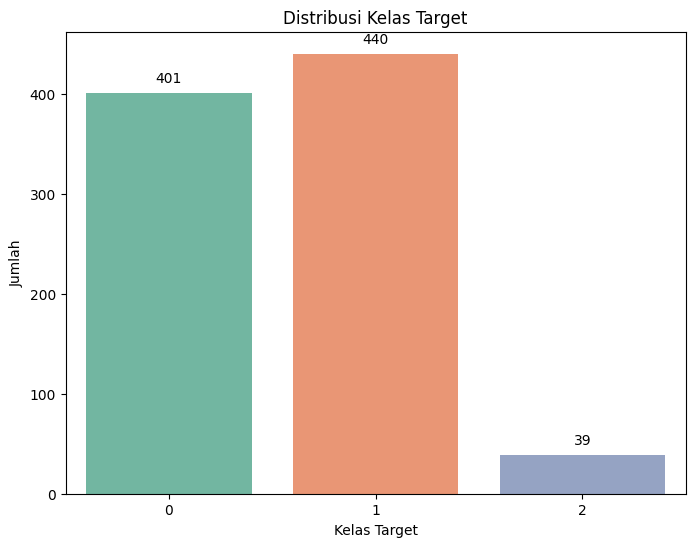

In [16]:
# Menghitung proporsi setiap kelas
class_counts = data_selected['Output'].value_counts()
print("Distribusi Kelas Target:\n", class_counts)

# Membuat bar plot untuk distribusi kelas target
plt.figure(figsize=(8, 6))
sns.countplot(x='Output', data=data_selected, palette='Set2')
plt.title('Distribusi Kelas Target')
plt.xlabel('Kelas Target')
plt.ylabel('Jumlah')

# Menambahkan anotasi pada setiap bar dengan jumlahnya
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [17]:
from imblearn.over_sampling import SMOTE

# Lakukan oversampling pada data latih
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
# Menampilkan ukuran data setelah oversampling
print("Ukuran data latih setelah oversampling (X_resampled, y_resampled):", len(X_resampled), len(y_resampled))

# Menampilkan distribusi kelas setelah oversampling
print("\nDistribusi kelas pada y_resampled:")
print(y_resampled.value_counts())

Ukuran data latih setelah oversampling (X_resampled, y_resampled): 1056 1056

Distribusi kelas pada y_resampled:
Output
1    352
2    352
0    352
Name: count, dtype: int64



=== Random Forest ===
Akurasi: 0.9034090909090909

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92        78
           1       0.93      0.88      0.90        88
           2       1.00      0.60      0.75        10

    accuracy                           0.90       176
   macro avg       0.93      0.82      0.86       176
weighted avg       0.91      0.90      0.90       176



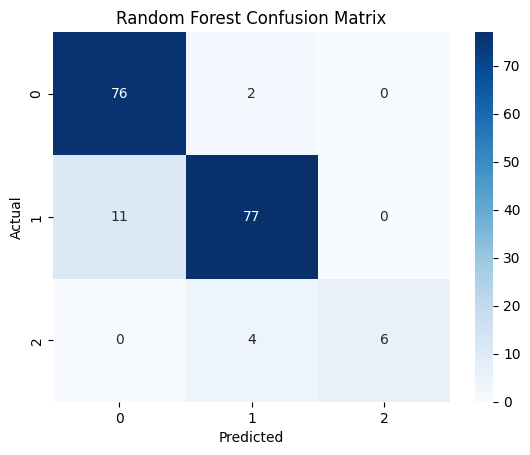

In [19]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
rf_predictions = rf_model.predict(X_test)

# Evaluasi Random Forest
print("\n=== Random Forest ===")
print("Akurasi:", accuracy_score(y_test, rf_predictions))
print("\nClassification Report:\n", classification_report(y_test, rf_predictions))

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:23:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
Akurasi: 0.8863636363636364

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91        78
           1       0.92      0.88      0.90        88
           2       0.80      0.40      0.53        10

    accuracy                           0.89       176
   macro avg       0.86      0.75      0.78       176
weighted avg       0.89      0.89      0.88       176



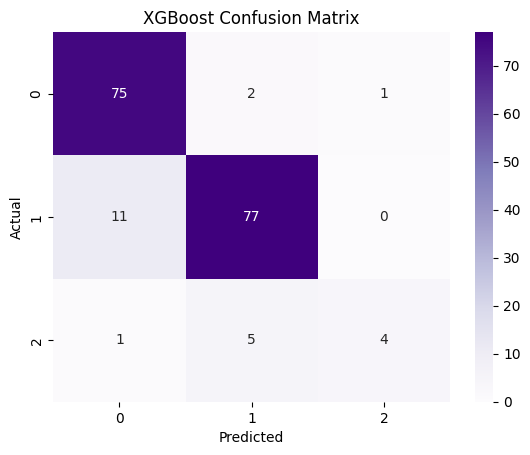

In [20]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)
xgb_predictions = xgb_model.predict(X_test)

# Evaluasi XGBoost
print("\n=== XGBoost ===")
print("Akurasi:", accuracy_score(y_test, xgb_predictions))
print("\nClassification Report:\n", classification_report(y_test, xgb_predictions))

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Purples')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



=== SVM ===
Akurasi: 0.7556818181818182

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88        78
           1       0.87      0.61      0.72        88
           2       0.28      0.90      0.43        10

    accuracy                           0.76       176
   macro avg       0.67      0.80      0.67       176
weighted avg       0.83      0.76      0.77       176



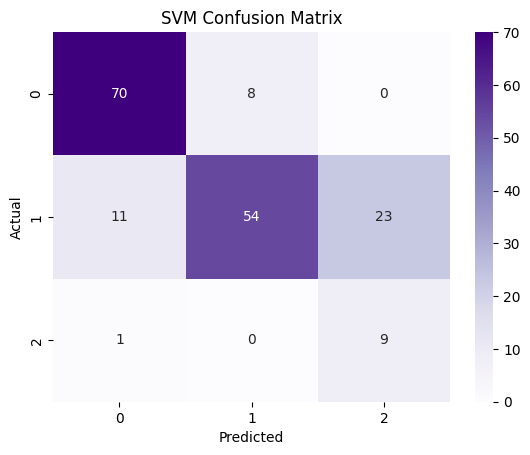

In [21]:
# SVM Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Inisialisasi dan pelatihan model SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_resampled, y_resampled)
svm_predictions = svm_model.predict(X_test)

# Evaluasi SVM
print("\n=== SVM ===")
print("Akurasi:", accuracy_score(y_test, svm_predictions))
print("\nClassification Report:\n", classification_report(y_test, svm_predictions))

# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_predictions)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Purples')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [22]:
import joblib
# Save Random Forest Model
joblib.dump(rf_model, '/content/drive/MyDrive/Data Mining/UAS/rf_model.pkl')
# Save XGBoost Model
joblib.dump(xgb_model, '/content/drive/MyDrive/Data Mining/UAS/xgb_model.pkl')

print("Model berhasil disimpan di Google Drive")

Model berhasil disimpan di Google Drive
